<a href="https://colab.research.google.com/github/pbeles/Project-3-Sentiment-Analysis-/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ========================================
# Environment Setup
# ========================================
!pip install --upgrade transformers torch seaborn matplotlib scikit-learn imbalanced-learn nltk emoji langdetect swifter vaderSentiment kaggle sentencepiece textblob
!pip install pandas
!pip install umap-learn
!pip install keybert
!pip install hdbscan --quiet
!pip install sentence-transformers --quiet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Columns in the DataFrame:
['platform', 'software', 'review', 'country', 'title', 'text', 'date', 'score', 'num_comments', 'subreddit', 'developerResponse', 'rating', 'isEdited', 'userName']

Sample rows:
   platform software                                             review  \
0  Facebook   Taxfix  Unfortunately, I had deposited the wrong finan...   
1  Facebook   Taxfix  Sinnloses Gendergestammel! \nWer mit der deuts...   
2  Facebook   Taxfix  Sistem generated emails. I sent 10 Emails and ...   
3  Facebook   Taxfix  Scheint wohl bald dicht zu machen. Support ant...   
4  Facebook   Taxfix  They locked me out of my account by revoking l...   

   country title text date  score  num_comments subreddit developerResponse  \
0  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
1  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
2  Germany   NaN  NaN  NaN    NaN           NaN       NaN               NaN   
3  Germany   NaN  NaN  NaN   

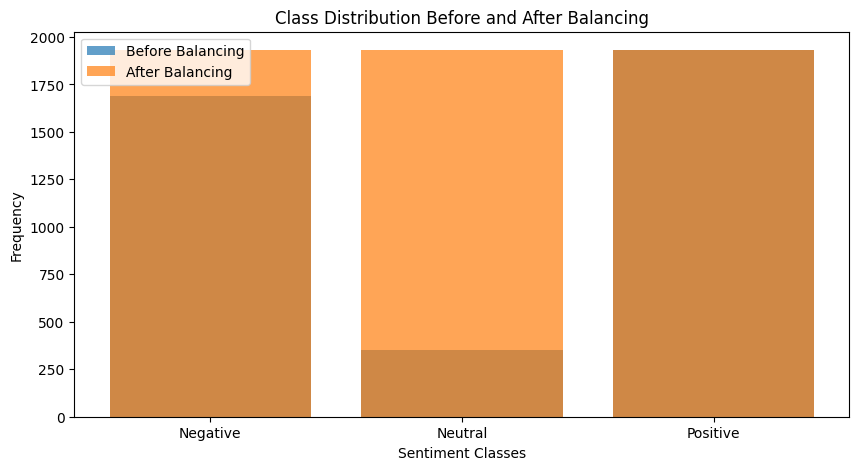

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilin

Training XLM-RoBERTa...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: pbeles (pbeles-ironhack). Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.546800,0.551781,0.792062,0.796173,0.792062,0.793422
2,0.512200,0.366515,0.895600,0.902414,0.895600,0.895894
3,0.191500,0.268009,0.928387,0.928793,0.928387,0.928107
4,0.152500,0.285150,0.944780,0.944957,0.944780,0.944542
5,0.075800,0.290534,0.946506,0.946679,0.946506,0.946210


Training mBERT...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.514400,0.551855,0.811044,0.839145,0.811044,0.812666
2,0.215000,0.286962,0.917170,0.920237,0.917170,0.916665
3,0.097400,0.261944,0.942192,0.944474,0.942192,0.941686
4,0.030500,0.254015,0.950820,0.951448,0.950820,0.950359
5,0.080200,0.263680,0.950820,0.951677,0.950820,0.950498


Evaluating XLM-RoBERTa...


XLM-RoBERTa Confusion Matrix:
[[364   6  16]
 [  3 382   1]
 [ 19  17 351]]
Evaluating mBERT...


mBERT Confusion Matrix:
[[371   6   9]
 [  3 383   0]
 [ 24  15 348]]
Generating predictions for ensemble...


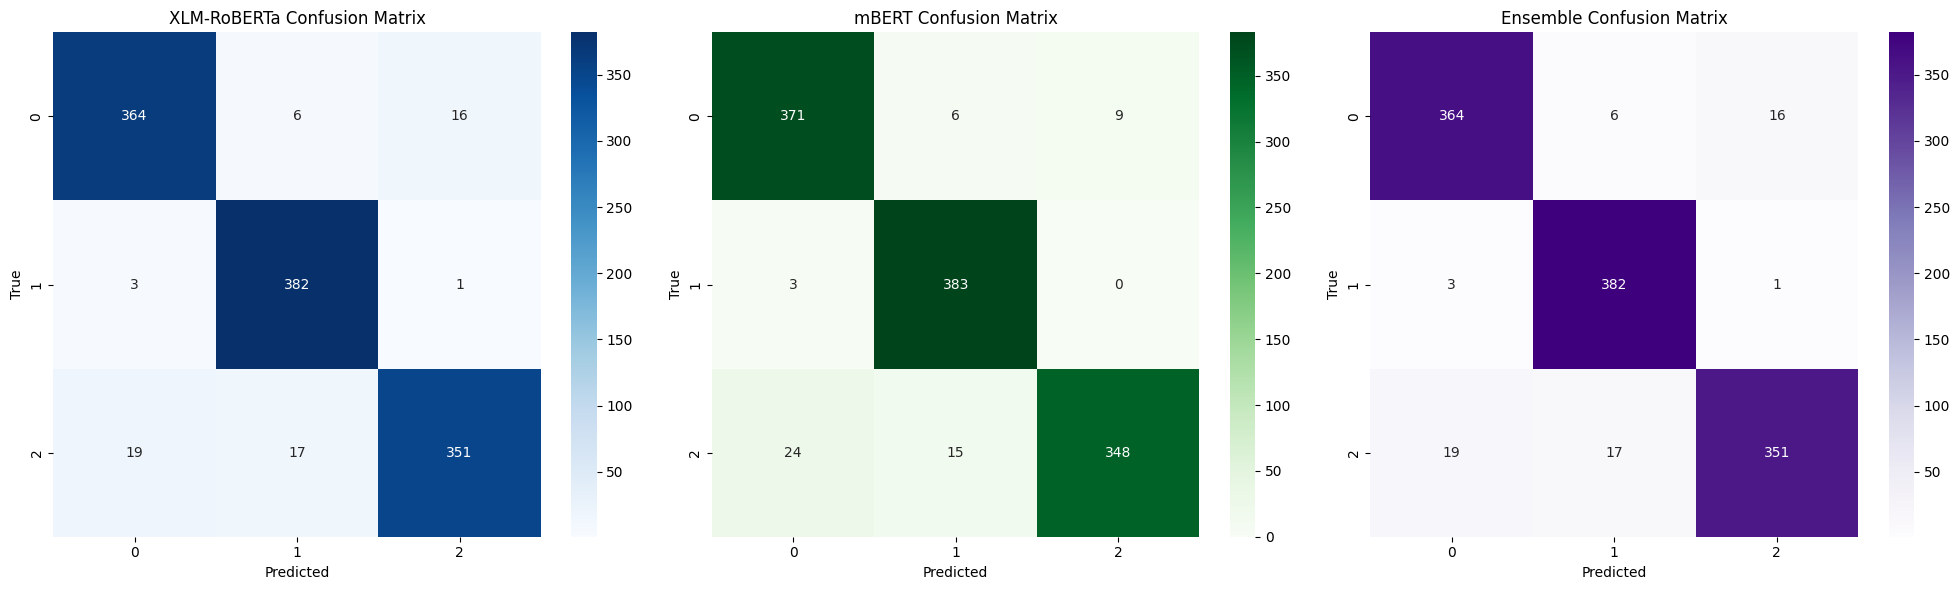

XLM-RoBERTa F1 Score: 0.9462099962509423
mBERT F1 Score: 0.9504979330090282
Ensemble F1 Score: 0.9462099962509423


('./mbert-sentiment/tokenizer_config.json',
 './mbert-sentiment/special_tokens_map.json',
 './mbert-sentiment/vocab.txt',
 './mbert-sentiment/added_tokens.json',
 './mbert-sentiment/tokenizer.json')

In [ ]:
# ========================================
# Setup and Environment Configuration
# ========================================
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.utils import resample
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import random
from transformers import (
    XLMRobertaTokenizer, XLMRobertaForSequenceClassification,
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments
)
import torch

# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Load the aggregated dataset
uploaded_data_path = "./aggregated_dataset.csv"  # I wrote it in order to ensure accessibility
try:
    df = pd.read_csv(uploaded_data_path)
except FileNotFoundError:
    raise FileNotFoundError(f"Dataset file not found at {uploaded_data_path}. Please ensure the file is placed correctly in the working directory.")

# Verify the structure of the dataset
print("Columns in the DataFrame:")
print(df.columns.tolist())
print("\nSample rows:")
print(df.head())

# ========================================
# Data Cleaning and Preprocessing
# ========================================
required_columns = ['review', 'rating']
for column in required_columns:
    if column not in df.columns:
        raise ValueError(f"The dataset must contain a '{column}' column.")

df = df.dropna(subset=['review', 'rating']).reset_index(drop=True)

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

df['cleaned_review'] = df['review'].apply(clean_text)

def rating_to_sentiment(r):
    if r < 3:
        return 0
    elif r == 3:
        return 1
    else:
        return 2

df['sentiment_label'] = df['rating'].apply(rating_to_sentiment)

# ========================================
# Data Balancing
# ========================================
class_counts = df['sentiment_label'].value_counts()
print("Class distribution before balancing:")
print(class_counts)

# Oversample minority classes to balance the dataset
df_majority = df[df['sentiment_label'] == class_counts.idxmax()]
df_minority = df[df['sentiment_label'] != class_counts.idxmax()]

balanced_dfs = [df_majority]
for label in df_minority['sentiment_label'].unique():
    minority_df = df_minority[df_minority['sentiment_label'] == label]
    oversampled_minority = resample(
        minority_df,
        replace=True,
        n_samples=len(df_majority),
        random_state=42
    )
    balanced_dfs.append(oversampled_minority)

df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print("Class distribution after balancing:")
print(df_balanced['sentiment_label'].value_counts())

# Plot class distributions
plt.figure(figsize=(10, 5))
plt.bar(class_counts.index, class_counts.values, alpha=0.7, label="Before Balancing")
plt.bar(df_balanced['sentiment_label'].value_counts().index, df_balanced['sentiment_label'].value_counts().values, alpha=0.7, label="After Balancing")
plt.xticks([0, 1, 2], ['Negative', 'Neutral', 'Positive'])
plt.xlabel("Sentiment Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution Before and After Balancing")
plt.legend()
plt.show()

#########################
# Save the cleaned and balanced dataset for future use
df_balanced.to_csv("./cleaned_balanced_dataset.csv", index=False)

# ========================================
# Model Ensemble: XLM-RoBERTa and mBERT
# ========================================
xlm_tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
xlm_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=3)

mbert_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
mbert_model = AutoModelForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=3)

# Tokenize dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df_balanced['cleaned_review'],
    df_balanced['sentiment_label'],
    test_size=0.2,
    random_state=42,
    stratify=df_balanced['sentiment_label']
)

xlm_train_encodings = xlm_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
xlm_val_encodings = xlm_tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

mbert_train_encodings = mbert_tokenizer(list(train_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")
mbert_val_encodings = mbert_tokenizer(list(val_texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

xlm_train_dataset = SentimentDataset(xlm_train_encodings, train_labels.tolist())
xlm_val_dataset = SentimentDataset(xlm_val_encodings, val_labels.tolist())

mbert_train_dataset = SentimentDataset(mbert_train_encodings, train_labels.tolist())
mbert_val_dataset = SentimentDataset(mbert_val_encodings, val_labels.tolist())

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_strategy="epoch"
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    return {
        "accuracy": (preds == labels).mean(),
        "precision": precision_score(labels, preds, average="weighted"),
        "recall": recall_score(labels, preds, average="weighted"),
        "f1": f1_score(labels, preds, average="weighted"),
    }

xlm_trainer = Trainer(
    model=xlm_model,
    args=training_args,
    train_dataset=xlm_train_dataset,
    eval_dataset=xlm_val_dataset,
    tokenizer=xlm_tokenizer,
    compute_metrics=compute_metrics
)

mbert_trainer = Trainer(
    model=mbert_model,
    args=training_args,
    train_dataset=mbert_train_dataset,
    eval_dataset=mbert_val_dataset,
    tokenizer=mbert_tokenizer,
    compute_metrics=compute_metrics
)

print("Training XLM-RoBERTa...")
xlm_trainer.train()
print("Training mBERT...")
mbert_trainer.train()

# Evaluate individual models
print("Evaluating XLM-RoBERTa...")
xlm_results = xlm_trainer.evaluate()
xlm_preds = np.argmax(xlm_trainer.predict(xlm_val_dataset).predictions, axis=1)
xlm_conf_matrix = confusion_matrix(val_labels, xlm_preds)
print("XLM-RoBERTa Confusion Matrix:")
print(xlm_conf_matrix)

print("Evaluating mBERT...")
mbert_results = mbert_trainer.evaluate()
mbert_preds = np.argmax(mbert_trainer.predict(mbert_val_dataset).predictions, axis=1)
mbert_conf_matrix = confusion_matrix(val_labels, mbert_preds)
print("mBERT Confusion Matrix:")
print(mbert_conf_matrix)

# Ensemble predictions
print("Generating predictions for ensemble...")
ensemble_preds = [Counter([x, y]).most_common(1)[0][0] for x, y in zip(xlm_preds, mbert_preds)]
ensemble_conf_matrix = confusion_matrix(val_labels, ensemble_preds)
ensemble_f1 = f1_score(val_labels, ensemble_preds, average="weighted")

# Plot confusion matrices
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
sns.heatmap(xlm_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title("XLM-RoBERTa Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(mbert_conf_matrix, annot=True, fmt='d', cmap='Greens', ax=axs[1])
axs[1].set_title("mBERT Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

sns.heatmap(ensemble_conf_matrix, annot=True, fmt='d', cmap='Purples', ax=axs[2])
axs[2].set_title("Ensemble Confusion Matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("True")

plt.tight_layout()
plt.show()

# Performance comparison
print("XLM-RoBERTa F1 Score:", xlm_results['eval_f1'])
print("mBERT F1 Score:", mbert_results['eval_f1'])
print("Ensemble F1 Score:", ensemble_f1)

# Save models and tokenizers
xlm_model.save_pretrained("./xlmr-sentiment")
xlm_tokenizer.save_pretrained("./xlmr-sentiment")
mbert_model.save_pretrained("./mbert-sentiment")
mbert_tokenizer.save_pretrained("./mbert-sentiment")
